# Описание проекта


Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

## Обзор данных

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

### Датафрейм calls

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.sample(5)

,id,call_date,duration,user_id
118493,1306_35,2018-12-21,6.69,1306
45108,1113_524,2018-09-30,9.65,1113
175580,1433_479,2018-11-27,0.00,1433
90212,1225_472,2018-05-17,3.15,1225
107878,1279_132,2018-12-05,16.47,1279


В таблице **calls** 4 столбца, пропущенные значения отсутствуют. 
1. **id** - уникальный номер звонка, формат object
2. **call_date** — дата звонка, формат object, нужно преобразовать его в формат datetime
3. **duration** - длительность звонка в минутах, формат float64
4.  **user_id** -  идентификатор пользователя, сделавшего звонок, формат int64 
Нули в столбце **duration** это пропущенные звонки, поэтому их не нужно удалять.

### Датафрейм internet

In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
7229,7229,1025_121,34.16,2018-05-27,1025
122996,122996,1414_89,448.89,2018-10-15,1414
114915,114915,1387_2,150.04,2018-12-23,1387
16835,16835,1058_11,299.35,2018-10-14,1058
29175,29175,1102_49,348.16,2018-10-18,1102


В таблице **internet** 5 столбцов, пропущенные значения отсутствуют. 
1. **Unnamed: 0** - непонятный столбец, которого не было в описании проекта. Возможно был выгружен по ошибке. 
2. **id** - уникальный номер сессии, формат object
3. **mb_used**  — объём потраченного за сессию интернет-трафика (в мегабайтах), формат float64
4. **session_date** - дата интернет-сессии, формат object, нужно преобразовать его в формат datetime
5. 	**user_id** -  идентификатор пользователя, формат int64 
Нули в столбце **duration** это пропущенные звонки, поэтому их не нужно удалять.

На первый взгляд столбец **Unnamed: 0** совпадает с индексами строк, проверим это:

In [7]:
(internet['Unnamed: 0'] == internet.index).count()

149396

Количество значений True равно количеству данных в датасете, значит столбец **Unnamed: 0** дублирует индексы датафрейма internet и мы можем его удалить.

Проверим на отрицательные значения столбцы **mb_used**, **user_id**, так как количество мегабайт и id пользователя не могут быть отрицательными.

In [8]:
print(f'Количество отрицательных значений в столбце {internet.columns[2]} равно {(internet.mb_used < 0).sum()}')
print(f'Количество отрицательных значений в столбце {internet.columns[3]} равно {(internet.user_id < 0).sum()}')

Количество отрицательных значений в столбце mb_used равно 0
Количество отрицательных значений в столбце session_date равно 0


Проверим датафрейм **internet** на дубликаты

In [9]:
print(f'Количество дубликатов равно {internet.duplicated().sum()}')

Количество дубликатов равно 0


### Датафрейм messages

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
messages.sample(5)

,id,message_date,user_id
122653,1497_20,2018-10-20,1497
46774,1203_159,2018-09-10,1203
73288,1310_157,2018-05-16,1310
29864,1130_239,2018-11-10,1130
83984,1350_128,2018-12-23,1350


В таблице **messages** 3 столбца, пропущенные значения отсутствуют. 
1. **id** - уникальный номер сообщения, формат object
2. **message_date**  — дата сообщения, формат object, нужно преобразовать его в формат datetime
3. **user_id** - дентификатор пользователя, отправившего сообщение, формат int64 


Проверим на отрицательные значения столбец **user_id**, так как id пользователей не могут быть отрицательными.

In [12]:
print(f'Количество отрицательных значений в столбце {messages.columns[2]} равно {(messages.user_id < 0).sum()}')

Количество отрицательных значений в столбце user_id равно 0


Проверим датафрейм **messages** на дубликаты

In [13]:
print(f'Количество дубликатов равно {messages.duplicated().sum()}')

Количество дубликатов равно 0


### Датафрейм tariffs

In [14]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [15]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице **tariffs** 7 столбцов, и две строки, пропущенные значения отсутствуют. 
1. **messages_included** - количество сообщений в месяц, включённых в абонентскую плату, формат int64
2. **mb_per_month_included** - объём интернет-трафика, включённого в абонентскую плату (в мегабайтах), формат int64
3. **rub_monthly_fee**  — ежемесячная абонентская плата в рублях, формат int64 
4. **rub_per_gb** - объём интернет-трафика, включённого в абонентскую плату (в мегабайтах), формат int64 
5. 	**rub_per_message** -   стоимость отправки сообщения сверх тарифного пакета в рублях, формат int64 
6. **rub_per_minute** - стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата), формат int64
7. **tariff_name** - название тарифа, формат object
Нули в столбце **duration** это пропущенные звонки, поэтому их не нужно удалять.

### Датафрейм users

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [17]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
257,1257,21,NaN,Санкт-Петербург,Габриель,Жданов,2018-06-17,ultra
435,1435,32,NaN,Москва,Евфросинья,Азимова,2018-02-17,smart
102,1102,28,NaN,Москва,Марта,Королькова,2018-06-16,smart
66,1066,47,NaN,Астрахань,Исак,Малахов,2018-06-24,smart
313,1313,56,NaN,Ставрополь,Онисим,Суслов,2018-10-24,smart


В таблице **users** 8 столбцов, пропущены значения в столбце **churn_date**. 
1. **user_id** - уникальный идентификатор пользователя, формат int64
2. **age** - возраст пользователя (годы), формат int64
3. **churn_date**  —  дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), формат object, , нужно преобразовать его в формат datetime
4. **city** - город проживания пользователя, формат object 
5. 	**first_name** -   имя пользователя, формат object 
6. **last_name** - фамилия пользователя, формат object
7. **reg_date** -дата подключения тарифа (день, месяц, год), формат object, нужно преобразовать его в формат datetime
8. **tariff** - название тарифного плана, формат object

Пропущенные значения есть только в столбце **churn_date** и они означают, что пользователь все ещё использует тариф. Проверим все ли города в столбце **city** начинаются с верхнего регистра, а также все ли наименования тарифов в столбце **tariff** начинаются с нижнего регистра. 

In [18]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [19]:
users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

Проверим столбец **age** на адекватность значений возраста пользователей

In [20]:
users['age'].unique()

array([52, 41, 59, 23, 68, 67, 21, 65, 63, 24, 26, 44, 38, 36, 64, 58, 73,
       71, 61, 72, 42, 56, 32, 62, 20, 51, 28, 66, 31, 37, 47, 40, 69, 48,
       33, 39, 43, 46, 45, 55, 53, 34, 49, 25, 18, 70, 50, 19, 54, 60, 29,
       27, 74, 22, 30, 75, 57, 35], dtype=int64)

Проверим регистр и содержание столбцов **first_name** и **last_name**

In [21]:
users['first_name'].unique()

array(['Рафаил', 'Иван', 'Евгений', 'Белла', 'Татьяна', 'Афанасий',
       'Леонид', 'Юна', 'Рустэм', 'Василиса', 'Эдуард', 'Веселина',
       'Варлам', 'Борис', 'Яков', 'Рузана', 'Марица', 'Мария', 'Матвей',
       'Игнатий', 'Тала', 'Святослав', 'Людмила', 'Иулиан', 'Владислав',
       'Рустем', 'Алексей', 'Мариетта', 'Лаврентий', 'Инна', 'Лия',
       'Розалия', 'Анжелика', 'Изольда', 'Агнесса', 'Юрий', 'Михаил',
       'Константин', 'Марианна', 'Иннокентий', 'Джемма', 'Екатерина',
       'Милица', 'Лола', 'Габриель', 'Кристина', 'Павел', 'Ренальд',
       'Луиза', 'Радислав', 'Динара', 'Лукий', 'Глеб', 'Тамара',
       'Александр', 'Таира', 'Роза', 'Исак', 'Юзефа', 'Ким', 'Гордей',
       'Эльза', 'Гектор', 'Андрей', 'Рафаэль', 'Фёдор', 'Харитон',
       'Еремей', 'Всеволод', 'Софья', 'Авксентий', 'Виолетта', 'Ириней',
       'Гелена', 'Ксения', 'Вера', 'Вениамин', 'Вероника', 'Даниэла',
       'Алла', 'Элеонора', 'Аюна', 'Руслан', 'Онисим', 'Марта', 'Эльвира',
       'Габриэль', '

In [22]:
users['last_name'].unique()

array(['Верещагин', 'Ежов', 'Абрамович', 'Белякова', 'Авдеенко', 'Горлов',
       'Ермолаев', 'Березина', 'Пономарёв', 'Блинова', 'Кононов',
       'Алёшко', 'Соловьев', 'Андреенко', 'Акинфьев', 'Алюшина',
       'Сазонова', 'Аленникова', 'Золотов', 'Круглов', 'Костина',
       'Тихонов', 'Трофимова', 'Мельникова', 'Антипов', 'Акинин',
       'Бородин', 'Авдеев', 'Евсеев', 'Селезнев', 'Русанова', 'Тимофеев',
       'Игнатьева', 'Бабушкина', 'Бондарев', 'Аракина', 'Андропова',
       'Архипова', 'Денисова', 'Одинцов', 'Кравцов', 'Добрынин',
       'Родионова', 'Рябов', 'Карасева', 'Александрова', 'Меркулова',
       'Мясникова', 'Ларин', 'Аничкина', 'Сомова', 'Панов', 'Фёдоров',
       'Платонова', 'Артемьев', 'Дьячкова', 'Глушков', 'Свиридов',
       'Рудаков', 'Ситникова', 'Коршунов', 'Климова', 'Алфеева',
       'Игнатова', 'Малахов', 'Абашкина', 'Демьянов', 'Кочетов',
       'Селиванова', 'Чумаков', 'Андрейкин', 'Павловский', 'Никулин',
       'Шарапов', 'Кольцова', 'Литвинов', 'Авр

Мы видим, что в столбцах, содержащих информацию об имени и фамилии пользователей существует как буква е так и буква ё, во избежания "множества сущностей" можно заменить букву ё на букву е. Проверим датафрейм **users** на дубликаты

In [23]:
print(f'Количество дубликатов равно {users.duplicated().sum()}')

Количество дубликатов равно 0


### Вывод

При анализе исходных датафреймов были найдены следующие особенности:
1. Все столбцы названы в формате snake_case
2. Все 5 датафреймов не содержат пропусков, которые связаны с человескими/системными ошибками. Пропуски в столбце **churn_date**  означают, что пользователь все еще пользуется тарифом, поэтому они не должны быть заполнены. 
3. Во всех таблицах отсутствуют дубликаты.
4. Столбец **call_date** датафрейма **calls** следует преобразовать к типу datetime для последующей работы с датами. 
5. Столбец **session_date** датафрейма **internet** следует преобразовать к типу datetime для последующей работы с датами. 
6. Столбец **message_date** датафрейма **messages** следует преобразовать к типу datetime для последующей работы с датами. 
7. Столбцы **churn_date**, **reg_date** датафрейма **users** следует преобразовать к типу datetime для последующей работы с датами. 
8. В таблице **users** можно заменить все ё на е в столбцах **city**, **first_name**, **last_name** для того чтобы не множить сущности. 


## Предобработка данных

Таким обрразом, в предобработке данных будут сделаны следующие шаги:
1. Преобразование столбцов **call_date, session_date, message_date, churn_date, reg_date** к формату datetime

In [24]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime( internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime( messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

2. Замена ё на е в столбцах **city**, **first_name**, **last_name** 

In [25]:
col_names = ['city', 'first_name', 'last_name']
for col in col_names:
    users[col] = users[col].str.replace('ё', 'е')

3. Удаление столбца **Unnamed: 0** в датафрейме интернет

In [26]:
internet = internet.drop('Unnamed: 0', axis=1)

### Вывод
Найденные проблемы при обзоре данных были устранены:
1. Столбец **call_date** датафрейма **calls** преобразован к типу datetime для последующей работы с датами. 
2. Столбец **session_date** датафрейма **internet** преобразован к типу datetime для последующей работы с датами. 
3. Столбец **message_date** датафрейма **messages** преобразован к типу datetime для последующей работы с датами. 
4. Столбцы **churn_date**, **reg_date** датафрейма **users** преобразованы к типу datetime для последующей работы с датами. 
5. Заменены все ё на е  в таблице **users**  в столбцах **city**, **first_name**, **last_name** для того чтобы не множить сущности. 
6. Удален столбец **Unnamed: 0** датафрейма **internet**, повторяющий индексацию этого датафрейма

Поскольку других явных проблем с данными найдено не было, перейдем к рассчетам. 

## Расчеты 

### Расчет количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
Для того, чтобы с группировать по месяцам датафрейм **calls**, создадим столбец **month** в котором будут месяцы из нашего столбца **call_date**. 

In [27]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

Для расчета мы сгруппируем данные по user_id и month, и применим функцию sum чтобы получить количество израсходованных минут, и функцию count для получения количества сделанных звонков. 

In [28]:
duration_calls_table = pd.pivot_table(calls, index=['user_id', 'month'],
                    values=['id', 'duration'], aggfunc={'id': 'count', 'duration':'sum'})

In [29]:
# переименование столбцов
duration_calls_table = duration_calls_table.rename(columns={
    'duration': 'duration_calls',
    'id': 'n_calls'})

In [30]:
duration_calls_table

duration_calls  n_calls
user_id month                              
1000    2018-05-01          150.06       22
        2018-06-01          158.90       43
        2018-07-01          318.80       47
        2018-08-01          389.87       52
        2018-09-01          440.14       58
...                            ...      ...
1498    2018-10-01          232.63       41
1499    2018-09-01           64.65        9
        2018-10-01          429.91       68
        2018-11-01          576.50       74
        2018-12-01          465.16       69

[3174 rows x 2 columns]

Проверим правильно ли посчитаны значения, рассчитав количество и продолжительность звонков для одного пользователя за один месяц

In [31]:
# количество потраченных минут 1000 юзера за май
calls[(calls['user_id'] == 1000) & (calls['month'] == '2018-05-01')]['duration'].sum()

150.05999999999997

In [32]:
# количество звонков  1000 юзера за май
calls[(calls['user_id'] == 1000) & (calls['month'] == '2018-05-01')]['user_id'].count()

22

### Расчет количества отправленных сообщений по месяцам по датафрейму **messages**. 
Для этого создадим столбец с месяцами отправки, и сгруппируем данные по месяцу и user_id, посчитав количество сообщений методом count()

In [33]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

In [34]:
n_messages_table = pd.pivot_table(messages, index=['user_id', 'month'],
                    values=['id'], aggfunc='count')
n_messages_table

id
user_id month         
1000    2018-05-01  22
        2018-06-01  60
        2018-07-01  75
        2018-08-01  81
        2018-09-01  57
...                 ..
1498    2018-10-01  42
1499    2018-09-01  11
        2018-10-01  48
        2018-11-01  59
        2018-12-01  66

[2717 rows x 1 columns]

In [35]:
# переименование столбцов
n_messages_table = n_messages_table.rename(columns={
    'id': 'n_messages'})

Проверим значение на правильность для польователя 1000 за май.

In [36]:
messages[(messages['user_id'] == 1000) & (messages['month'] == '2018-05-01')]['user_id'].count()

22

### Объем израсходованного интернет-трафика по месяцам по датафрейму **internet** 

In [37]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

In [38]:
internet_traffic_table = pd.pivot_table(internet, index=['user_id', 'month'],
                    values='mb_used', aggfunc='sum')
internet_traffic_table

mb_used
user_id month               
1000    2018-05-01   2253.49
        2018-06-01  23233.77
        2018-07-01  14003.64
        2018-08-01  14055.93
        2018-09-01  14568.91
...                      ...
1498    2018-10-01  20579.36
1499    2018-09-01   1845.75
        2018-10-01  17788.51
        2018-11-01  17963.31
        2018-12-01  13055.58

[3203 rows x 1 columns]

In [39]:
# переименование столбцов
internet_traffic_table = internet_traffic_table.rename(columns={
    'mb_used': 'n_traffic'})

Проверим адекватность полученных значений для одного пользователя и одного месяца

In [40]:
internet[(internet['user_id'] == 1000) & (internet['month'] == '2018-05-01')]['mb_used'].sum()

2253.49

### Расчет помесячной выручки с каждого пользователя 
(вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).

In [41]:
# объединение данных для расчетов
calls_message_df = duration_calls_table.join(n_messages_table)
calls_message_traffic_df = calls_message_df.join(internet_traffic_table)

Для объединения таблицы **calls_message_traffic_df** с таблицей **users** необходимо избавиться от мультииндексов, так как месяцы сейчас являются вторым индексом данного датафрейма. Затем произведем объединение с **users**

In [42]:
calls_message_traffic_df =  calls_message_traffic_df.reset_index(level = 1)

In [43]:
calls_message_traffic_df['n_messages'] = calls_message_traffic_df['n_messages'].fillna(0)
calls_message_traffic_df['n_traffic'] = calls_message_traffic_df['n_traffic'].fillna(0)

In [44]:
month_user_table = calls_message_traffic_df.merge(users, how='left', on='user_id')
month_user_table

,user_id,month,duration_calls,n_calls,n_messages,n_traffic,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,150.06,22,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,158.90,43,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,318.80,47,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,389.87,52,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,440.14,58,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,2018-10-01,232.63,41,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
3170,1499,2018-09-01,64.65,9,11.0,1845.75,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3171,1499,2018-10-01,429.91,68,48.0,17788.51,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart
3172,1499,2018-11-01,576.50,74,59.0,17963.31,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


Последним действием объеденим нашу таблицу с таблицей, с информацией о тарифах **tariffs**

In [45]:
total_df = month_user_table.merge(tariffs, how='left', left_on=['tariff'], right_on = ['tariff_name'])
total_df

,user_id,month,duration_calls,n_calls,n_messages,n_traffic,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,2018-05-01,150.06,22,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,2018-06-01,158.90,43,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,2018-07-01,318.80,47,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,2018-08-01,389.87,52,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,2018-09-01,440.14,58,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,2018-10-01,232.63,41,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,...,2018-07-19,smart,50,15360,500,550,200,3,3,smart
3170,1499,2018-09-01,64.65,9,11.0,1845.75,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,smart
3171,1499,2018-10-01,429.91,68,48.0,17788.51,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,smart
3172,1499,2018-11-01,576.50,74,59.0,17963.31,35,NaT,Пермь,Гектор,...,2018-09-27,smart,50,15360,500,550,200,3,3,smart


Для нахождения минут вне тарифа вычтем из потраченных минут сколько минут было в тарифе. Если значение отрицательное (пользователь не потратил все минуты, примем его за ноль, так как эти пользователи не принесут выручки вне тарифа). Округлим  до целых минут в большую сторону.

In [46]:
total_df['min_out_tariff'] = total_df['duration_calls'] - total_df['minutes_included']
total_df['min_out_tariff'] = total_df['min_out_tariff'].clip(lower=0)
total_df['min_out_tariff'] = total_df['min_out_tariff'].apply(np.ceil)

Аналогично узнаем какие пользователи вышли за рамки тарифа по сообщениям. 

In [47]:
total_df['mes_out_tariff'] = total_df['n_messages'] - total_df['messages_included']
total_df['mes_out_tariff'] = total_df['mes_out_tariff'].clip(lower=0)

Проведем ту же операцию для интернет трафика, округлим мегабайты до гигабайт в большую сторону. 

In [48]:
total_df['gb_out_tariff'] = total_df['n_traffic'] - total_df['mb_per_month_included']
total_df['gb_out_tariff'] = total_df['gb_out_tariff'].clip(lower=0)
total_df['gb_out_tariff'] = np.ceil(total_df['gb_out_tariff']/1024)  #в гигабайтах

Для нахождения прибыли с пользователя прибавим к цене тарифа количество минут вне тарифа, умноженное на цену за минуту. Аналогично для интернет трафика и сообщений. 

In [49]:
# income - столбец с итоговой ежемесячной прибылью по пользователям 

total_df['income'] = total_df['rub_monthly_fee'] + (total_df['min_out_tariff'] * total_df['rub_per_minute']) + (total_df['mes_out_tariff'] * total_df['rub_per_message']) + (total_df['gb_out_tariff'] * total_df['rub_per_gb'])

### Вывод
В данном разделе были рассчитаны следующие величины:
1. Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя. Для этого был создан столбец с месяцем, данные были сгруппированы по уникальному номеру пользователя и месяцу, и с помощью функций sum и count расчитаны израсходованные минуты и количество звонков. Была сделана проверка правильности расчетов. 
2. Количество отправленных сообщений по месяцам по датафрейму messages. Для этого был создан столбец с месяцем, данные были сгруппированы по уникальному номеру пользователя и месяцу, и с помощью функции count расчитано количество отправленных сообщений. Была сделана проверка правильности расчетов. 
3. Объем израсходованного интернет-трафика по месяцам. Для этого был создан столбец с месяцем, данные были сгруппированы по уникальному номеру пользователя и месяцу, и с помощью функции count расчитано количество отправленных сообщений. Была сделана проверка правильности расчетов. 
4. Помесячная выручка с каждого пользователя. Для этого все данные были объединены в общий датафрейм. На первом шаге бесплатный лимит был вычтен из суммарного количества звонков, сообщений и интернет-трафика. Полученные значения вне лимита были округлены, домножены на стоимость по тарифу, и затем прибавлены к абонентской плате. 

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Округлим значения **duration_calls**, **n_traffic** до целых минут и гигабайт

In [50]:
total_df['duration_calls_ceil'] = np.ceil(total_df['duration_calls'])
total_df['n_traffic_ceil_gb'] = np.ceil(total_df['n_traffic']/1024)
total_df

,user_id,month,duration_calls,n_calls,n_messages,n_traffic,age,churn_date,city,first_name,...,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,min_out_tariff,mes_out_tariff,gb_out_tariff,income,duration_calls_ceil,n_traffic_ceil_gb
0,1000,2018-05-01,150.06,22,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,150,1,1,ultra,0.0,0.0,0.0,1950.0,151.0,3.0
1,1000,2018-06-01,158.90,43,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,150,1,1,ultra,0.0,0.0,0.0,1950.0,159.0,23.0
2,1000,2018-07-01,318.80,47,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,150,1,1,ultra,0.0,0.0,0.0,1950.0,319.0,14.0
3,1000,2018-08-01,389.87,52,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,150,1,1,ultra,0.0,0.0,0.0,1950.0,390.0,14.0
4,1000,2018-09-01,440.14,58,57.0,14568.91,52,NaT,Краснодар,Рафаил,...,150,1,1,ultra,0.0,0.0,0.0,1950.0,441.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,2018-10-01,232.63,41,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,...,200,3,3,smart,0.0,0.0,6.0,1750.0,233.0,21.0
3170,1499,2018-09-01,64.65,9,11.0,1845.75,35,NaT,Пермь,Гектор,...,200,3,3,smart,0.0,0.0,0.0,550.0,65.0,2.0
3171,1499,2018-10-01,429.91,68,48.0,17788.51,35,NaT,Пермь,Гектор,...,200,3,3,smart,0.0,0.0,3.0,1150.0,430.0,18.0
3172,1499,2018-11-01,576.50,74,59.0,17963.31,35,NaT,Пермь,Гектор,...,200,3,3,smart,77.0,9.0,3.0,1408.0,577.0,18.0


Разделим значения по операторам в разные датафреймы и сгруппируем для получения ежемесячных характеристик

In [51]:
df_smart = total_df[total_df['tariff_name'] == 'smart'] 
df_ultra = total_df[total_df['tariff_name'] == 'ultra'] 

In [52]:
pivot_smart = pd.pivot_table(df_smart, index=['month'], 
                      values=['duration_calls_ceil', 'n_traffic_ceil_gb', 'n_messages'], aggfunc='mean')
pivot_ultra = pd.pivot_table(df_ultra, index=['month'], 
                      values=['duration_calls_ceil', 'n_traffic_ceil_gb', 'n_messages'], aggfunc='mean')

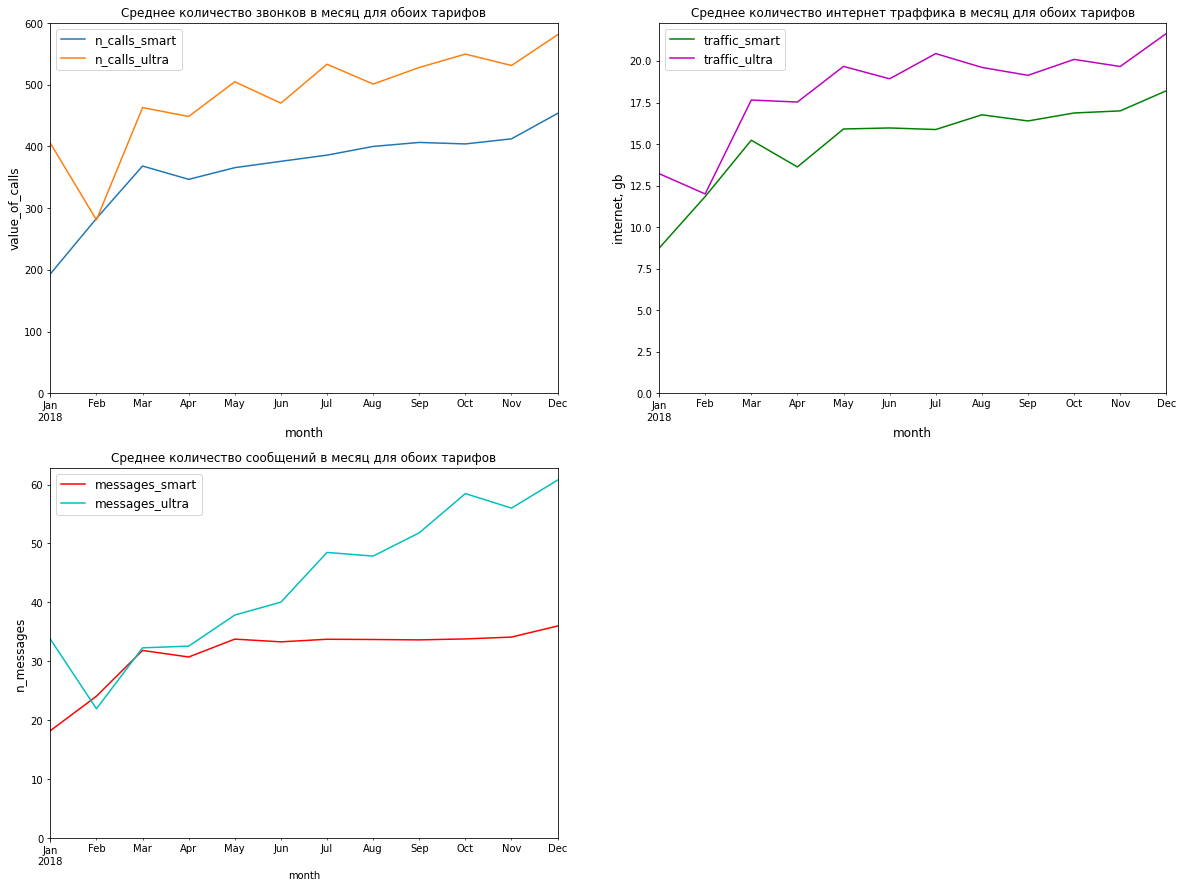

In [53]:
fig = plt.figure(figsize = (20, 15))
ax1 = fig.add_subplot(221)
pivot_smart['duration_calls_ceil'].plot(label = 'n_calls_smart')
pivot_ultra['duration_calls_ceil'].plot(label = 'n_calls_ultra')
ax1.set_ylabel('value_of_calls', fontsize=12)
ax1.set_xlabel('month', fontsize=12)
ax1.set_ylim(0)
ax1.set_title('Среднее количество звонков в месяц для обоих тарифов', fontsize=12)
ax1.legend(fontsize=12)
ax2 = fig.add_subplot(222)
pivot_smart['n_traffic_ceil_gb'].plot(label = 'traffic_smart', color = 'g')
pivot_ultra['n_traffic_ceil_gb'].plot(label = 'traffic_ultra', color = 'm')
ax2.set_ylabel('internet, gb', fontsize=12)
ax2.set_xlabel('month', fontsize=12)
ax2.set_ylim(0)
ax2.set_title('Среднее количество интернет траффика в месяц для обоих тарифов', fontsize=12)
ax2.legend(fontsize=12)
ax3 = fig.add_subplot(223)
pivot_smart['n_messages'].plot(label = 'messages_smart', color = 'r')
pivot_ultra['n_messages'].plot(label = 'messages_ultra', color = 'c')
ax3.set_ylabel('n_messages', fontsize=12)
ax3.set_ylim(0)
ax3.set_title('Среднее количество сообщений в месяц для обоих тарифов', fontsize=12)
ax3.legend(fontsize=12)
plt.show()

Средние значения для тарифа смарт: 
1. от 193 до 453 минут в месяц
2. От 9 до 18 гигабайт в месяц
3. От 20 до 42 сообщений в месяц


Средние значения для тарифа ультра: 
1. от 281 до 581 минут в месяц
2. От 13 до 22 гигабайт в месяц
3. От 33 до 72 сообщений в месяц

По графикам среднего количества интернета, звонков и оправленных сообщений мы видим, что пользователи тарифа ультра используют звонки, интернет и сообщения больше, чем пользователи тарифа смарт. Посмотрим насколько больше. 

In [54]:
print('Количество звонков пользователей тарифа смарт составляет', np.round(100*(pivot_smart['duration_calls_ceil']/pivot_ultra['duration_calls_ceil']).mean()), '% от тарифа ультра')
print('Интернет трафик пользователей тарифа смарт составляет', np.round(100*(pivot_smart['n_traffic_ceil_gb']/pivot_ultra['n_traffic_ceil_gb']).mean()), '% от тарифа ультра')
print('Количество смс сообщений пользователей тарифа смарт составляет', np.round(100*(pivot_smart['n_messages']/pivot_ultra['n_messages']).mean()), '% от тарифа ультра')

Количество звонков пользователей тарифа смарт составляет 76.0 % от тарифа ультра
Интернет трафик пользователей тарифа смарт составляет 83.0 % от тарифа ультра
Количество смс сообщений пользователей тарифа смарт составляет 76.0 % от тарифа ультра


Расчитаем среднее, дисперсию и стандартное отклонение

In [55]:
print('Среднее количество минут для тарифа смарт составляет', np.round(pivot_smart['duration_calls_ceil'].mean(), decimals = 2),
     'для тарифа ультра',  np.round(pivot_ultra['duration_calls_ceil'].mean(), decimals = 2))
print('Среднее количество интернет трафика для тарифа смарт составляет', np.round(pivot_smart['n_traffic_ceil_gb'].mean(), decimals = 2),
     'для тарифа ультра',  np.round(pivot_ultra['n_traffic_ceil_gb'].mean(), decimals = 2))
print('Среднее количество сообщений для тарифа смарт составляет', np.round(pivot_smart['n_messages'].mean(), decimals = 2),
     'для тарифа ультра',  np.round(pivot_ultra['n_messages'].mean(), decimals = 2))


Среднее количество минут для тарифа смарт составляет 366.37 для тарифа ультра 483.11
Среднее количество интернет трафика для тарифа смарт составляет 15.2 для тарифа ультра 18.3
Среднее количество сообщений для тарифа смарт составляет 31.42 для тарифа ультра 43.49


In [56]:
print('Дисперсия для количества звонков тарифа смарт составляет', np.round(np.var(pivot_smart['duration_calls_ceil']), decimals = 2),
             'cтандартное отклонение', np.round(math.sqrt(np.var(pivot_smart['duration_calls_ceil'])), decimals = 2))
print('Дисперсия для интернет трафика тарифа смарт составляет', np.round(np.var(pivot_smart['n_traffic_ceil_gb']), decimals = 2),
             'cтандартное отклонение', np.round(math.sqrt(np.var(pivot_smart['n_traffic_ceil_gb'])),  decimals = 2))
print('Дисперсия для количества сообщений тарифа смарт составляет', np.round(np.var(pivot_smart['n_messages']), decimals = 2),
             'cтандартное отклонение', np.round(math.sqrt(np.var(pivot_smart['n_messages'])),  decimals = 2))

Дисперсия для количества звонков тарифа смарт составляет 4294.09 cтандартное отклонение 65.53
Дисперсия для интернет трафика тарифа смарт составляет 6.33 cтандартное отклонение 2.52
Дисперсия для количества сообщений тарифа смарт составляет 23.91 cтандартное отклонение 4.89


In [57]:
print('Дисперсия для количества звонков тарифа ультра составляет', np.round(np.var(pivot_ultra['duration_calls_ceil']), decimals = 2),
             'cтандартное отклонение', np.round(math.sqrt(np.var(pivot_ultra['duration_calls_ceil'])), decimals = 2))
print('Дисперсия для интернет трафика тарифа ультра составляет', np.round(np.var(pivot_ultra['n_traffic_ceil_gb']), decimals = 2),
             'cтандартное отклонение', np.round(math.sqrt(np.var(pivot_ultra['n_traffic_ceil_gb'])),  decimals = 2))
print('Дисперсия для количества сообщений тарифа ультра составляет', np.round(np.var(pivot_ultra['n_messages']), decimals = 2),
             'cтандартное отклонение', np.round(math.sqrt(np.var(pivot_ultra['n_messages'])),  decimals = 2))

Дисперсия для количества звонков тарифа ультра составляет 5853.69 cтандартное отклонение 76.51
Дисперсия для интернет трафика тарифа ультра составляет 7.67 cтандартное отклонение 2.77
Дисперсия для количества сообщений тарифа ультра составляет 136.48 cтандартное отклонение 11.68


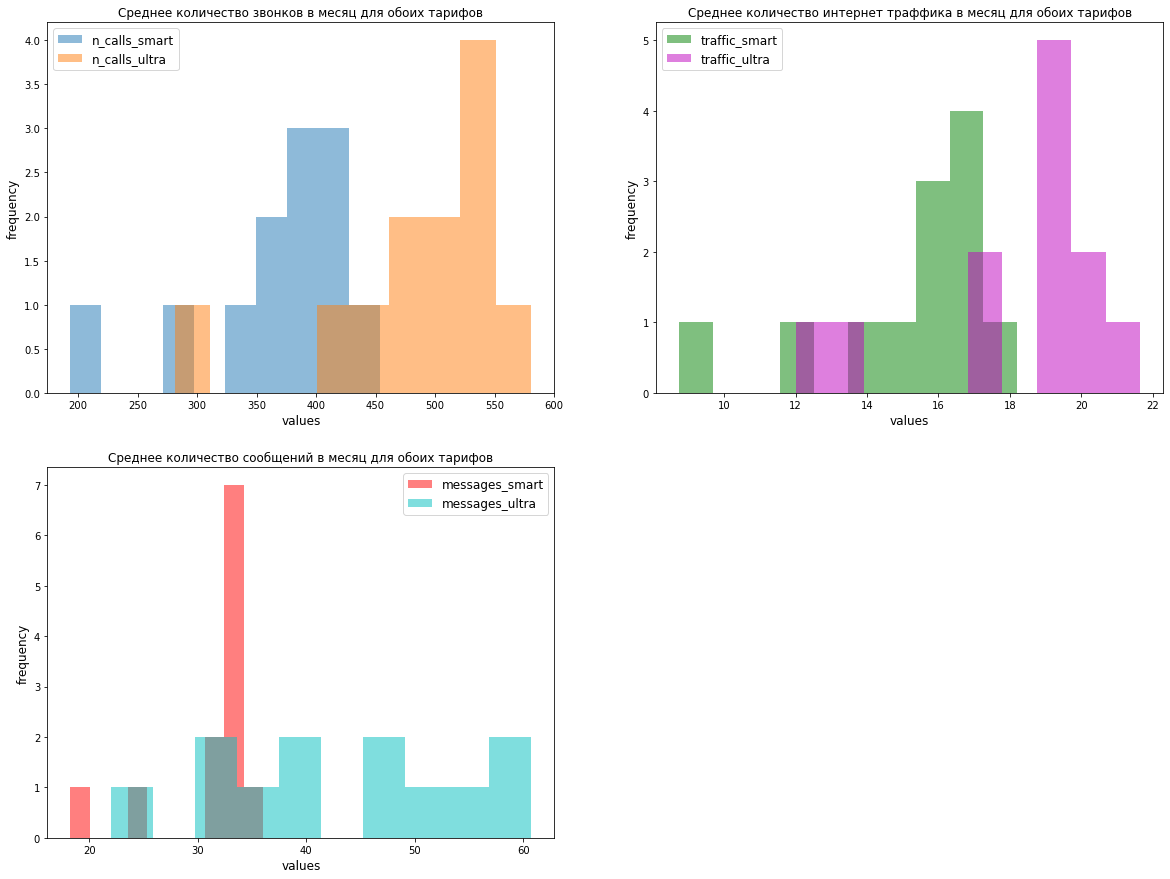

In [58]:
fig = plt.figure(figsize = (20, 15))
ax1 = fig.add_subplot(221)
pivot_smart['duration_calls_ceil'].plot(kind = 'hist',  alpha = 0.5,  label = 'n_calls_smart')
pivot_ultra['duration_calls_ceil'].plot(kind = 'hist',alpha = 0.5, label = 'n_calls_ultra')
ax1.set_ylabel('frequency', fontsize=12)
ax1.set_xlabel('values', fontsize=12)
ax1.set_title('Среднее количество звонков в месяц для обоих тарифов', fontsize=12)
ax1.legend(fontsize=12)
ax2 = fig.add_subplot(222)
pivot_smart['n_traffic_ceil_gb'].plot(kind = 'hist',alpha = 0.5, label = 'traffic_smart', color = 'g')
pivot_ultra['n_traffic_ceil_gb'].plot(kind = 'hist',alpha = 0.5, label = 'traffic_ultra', color = 'm')
ax2.set_ylabel('frequency', fontsize=12)
ax2.set_xlabel('values', fontsize=12)
ax2.set_title('Среднее количество интернет траффика в месяц для обоих тарифов', fontsize=12)
ax2.legend(fontsize=12)
ax3 = fig.add_subplot(223)
pivot_smart['n_messages'].plot(kind = 'hist',alpha = 0.5, label = 'messages_smart', color = 'r')
pivot_ultra['n_messages'].plot(kind = 'hist',alpha = 0.5, label = 'messages_ultra', color = 'c')
ax3.set_ylabel('frequency', fontsize=12)
ax3.set_xlabel('values', fontsize=12)
ax3.set_ylim(0)
ax3.set_title('Среднее количество сообщений в месяц для обоих тарифов', fontsize=12)
ax3.legend(fontsize=12)
plt.show()

По анализу гистограмм, дисперсии и стандартного отклонения были получены следующие выводы:
1. По всем трем анализируемым величинам дисперсия и стандартное отклонение больше для пользователей тарифа смарт, это значит, что в значениях для тарифа ультра присутствует больший разброс между средними показателями (медиана, среднее) и значениями выборки, что говорит о большей неоднородности поведения пользователей данного тарифа.Наиболее часто встречающиеся значения для тарифа смарт 360 - 420 минут, для тарифа ультра в окрестности 525 - 550 минут. 
2. Распределения для количества минут для обоих тарифов похожи и напоминают нормальное, смещенное влево
3. Распределения для интернет трафика для обоих тарифов похожи и напоминают нормальное. Наиболее часто встречающиеся значения для тарифа смарт 16.5 - 16.5 гигабайт, для тарифа ультра в окрестности 20 гигабайт. 
4. Распределение для количества сообщений тарифа ультра не имеет наиболее часто встречающегося значения, для тарифа смарт самые часто встречающиеся значения расположены между 36 и 41 собщениями.  

###  Выводы
- Средние значения тарифа **смарт** находятся в промежутках от 193 до 453 минут в месяц **Среднее 366.37**, от 9 до 18 гигабайт в месяц **среднее 15.21**,  и от 20 до 42 сообщений в месяц **среднее 36.28**. 
- Для тарифа **ультра** они лежат в пределах от 281 до 581 минут в месяц **среднее 483.11** , от 13 до 22 гигабайт в месяц **среднее 18.53**, от 33 до 72 сообщений в месяц **среднее 55.21**
- Пользователи тарифа ультра используют звонки, интернет и сообщения больше, чем пользователи тарифа смарт. Причем количество звонков пользователей тарифа смарт составляет 76.0 % от тарифа ультра, интернет трафик пользователей тарифа смарт составляет 82.0 % от тарифа ультра, количество смс сообщений пользователей тарифа смарт составляет 67.0 % от тарифа ультра
- По всем трем анализируемым величинам дисперсия и стандартное отклонение больше для пользователей тарифа смарт, это значит, что в значениях для тарифа ультра присутствует больший разброс между средними показателями (медиана, среднее) и значениями выборки, что говорит о большей неоднородности поведения пользователей данного тарифа.Наиболее часто встречающиеся значения для тарифа смарт 360 - 420 минут, для тарифа ультра в окрестности 525 - 550 минут.
- Распределения для количества минут для обоих тарифов похожи и напоминают нормальное, смещенное влево
- Распределения для интернет трафика для обоих тарифов похожи и напоминают нормальное. Наиболее часто встречающиеся значения для тарифа смарт 16.5 - 16.5 гигабайт, для тарифа ультра в окрестности 20 гигабайт.
- Распределение для количества сообщений тарифа ультра не имеет наиболее часто встречающегося значения, для тарифа смарт самые часто встречающиеся значения расположены между 36 и 41 собщениями.

## Проверка статистических гипотез

### **Гипотеза 1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются**

Получается, что нулевая гипотеза звучит так: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
Алтернативная: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [59]:
df_smart

,user_id,month,duration_calls,n_calls,n_messages,n_traffic,age,churn_date,city,first_name,...,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,min_out_tariff,mes_out_tariff,gb_out_tariff,income,duration_calls_ceil,n_traffic_ceil_gb
8,1001,2018-11-01,408.12,59,0.0,18429.34,41,NaT,Москва,Иван,...,200,3,3,smart,0.0,0.0,3.0,1150.0,409.0,18.0
9,1001,2018-12-01,391.34,63,0.0,14036.66,41,NaT,Москва,Иван,...,200,3,3,smart,0.0,0.0,0.0,550.0,392.0,14.0
10,1002,2018-06-01,110.37,15,4.0,10856.82,59,NaT,Стерлитамак,Евгений,...,200,3,3,smart,0.0,0.0,0.0,550.0,111.0,11.0
11,1002,2018-07-01,204.75,26,11.0,17580.10,59,NaT,Стерлитамак,Евгений,...,200,3,3,smart,0.0,0.0,3.0,1150.0,205.0,18.0
12,1002,2018-08-01,269.71,42,13.0,20319.26,59,NaT,Стерлитамак,Евгений,...,200,3,3,smart,0.0,0.0,5.0,1550.0,270.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,2018-10-01,232.63,41,42.0,20579.36,68,2018-10-25,Владикавказ,Всеволод,...,200,3,3,smart,0.0,0.0,6.0,1750.0,233.0,21.0
3170,1499,2018-09-01,64.65,9,11.0,1845.75,35,NaT,Пермь,Гектор,...,200,3,3,smart,0.0,0.0,0.0,550.0,65.0,2.0
3171,1499,2018-10-01,429.91,68,48.0,17788.51,35,NaT,Пермь,Гектор,...,200,3,3,smart,0.0,0.0,3.0,1150.0,430.0,18.0
3172,1499,2018-11-01,576.50,74,59.0,17963.31,35,NaT,Пермь,Гектор,...,200,3,3,smart,77.0,9.0,3.0,1408.0,577.0,18.0


In [60]:
smart_income = df_smart['income']
ultra_income = df_ultra['income']

In [61]:
smart_income

8       1150.0
9        550.0
10       550.0
11      1150.0
12      1550.0
         ...  
3169    1750.0
3170     550.0
3171    1150.0
3172    1408.0
3173     598.0
Name: income, Length: 2223, dtype: float64

In [62]:
alpha = .05
results = st.ttest_ind(
    smart_income, 
    ultra_income)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  7.475374971740913e-173
Отвергаем нулевую гипотезу


### **Гипотеза 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

За нулевую гипотезу возьмем: Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. 
Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [63]:
total_income_moscow = total_df[total_df['city'] == 'Москва']['income']
total_income_region = total_df[total_df['city'] != 'Москва']['income']

In [64]:
alpha = .05
results = st.ttest_ind(
    total_income_moscow, 
    total_income_region)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.40159107364529
Не получилось отвергнуть нулевую гипотезу


### Вывод
1. Первая нулевая гипотеза отвергнута, таким образом средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
2. Во втором случае нулевая гипотеза подтвердилась, таким образом Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов

## Общий вывод

1. Работа была произведена с достаточно "чистыми" датасетами, на этапе предобработки столбцы **call_date** датафрейма **calls**, **session_date** датафрейма **internet**, **message_date** датафрейма **messages**, **churn_date**, **reg_date** датафрейма **users** были  преобразованы к типу datetime для последующей работы с датами. Также  В таблице **users** были заменены все ё на е в столбцах **city**, **first_name**, **last_name**. Удален столбец **Unnamed: 0** датафрейма **internet**, повторяющий индексацию этого датафрейма
2. Таблицы были объеденены в общую. Были рассчитаны следующие величины количества сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя,  количества отправленных сообщений по месяцам по датафрейму messages, объем израсходованного интернет-трафика по месяцам,  Помесячная выручка с каждого пользователя. 
3. При анализе данных были получены следующие выводы:
    - По всем трем анализируемым величинам дисперсия и стандартное отклонение больше для пользователей тарифа смарт, это значит, что в значениях для тарифа ультра присутствует больший разброс между средними показателями (медиана, среднее) и значениями выборки, что говорит о большей неоднородности поведения пользователей данного тарифа.Наиболее часто встречающиеся значения для тарифа смарт 360 - 420 минут, для тарифа ультра в окрестности 525 - 550 минут. 
    - Распределения для количества минут для обоих тарифов похожи и напоминают нормальное, смещенное влево
    - Распределения для интернет трафика для обоих тарифов похожи и напоминают нормальное. Наиболее часто встречающиеся значения для тарифа смарт 16.5 - 16.5 гигабайт, для тарифа ультра в окрестности 20 гигабайт. 
    - Распределение для количества сообщений тарифа ультра не имеет наиболее часто встречающегося значения, для тарифа смарт самые часто встречающиеся значения расположены между 36 и 41 собщениями.  
4. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов